##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

# A quick gothrough of the model

## Data Analysis

### Data Cleaning

1. Flag and Fill the missing values:

2. Handle non-numeric data (e.g. categorical and date)

### Feature Engineering and Selection

1. Drop some irrelevant or intermediate columns with domain knowledge (e.g. hh_20 is an intermediate column used to find hh_size_est columns)

2. Combine some columns with similar meanings (e.g. combine is_consent_to_email/call/mail/... columns to consent indicator columns) <br>
The detailed explanation of all new features added can be found below.

3. Drop columns with low variance.

4. Drop columns with low correlation with the target columns (visualized correlation graph can be found in appendix).

5. Identify pairs of columns with high correlation and only keep one for each pair.

6. Drop columns with small p-value. (Not sure if needed)

7. Note that since we are using xgbtree model, featrue scaling is not helpful and we did not include it in our final model even though we attempted scaling along the way of exploration.

## Modelling

### Handling Imbalanced Data

1. We use SMOTE method to upsample the minority class (i.e. 1) since the proportion of positive sample is low (at around 4%). We also tried other approaches including mix of upsampling and downsampling, it turns out that SMOTE gives the best performance.

### New features

New features are created using existing features, such that: 

1. We scale down the dimensions of the input to reduce the effect of curse of dimensionality;

2. We combine columns with high correlation to reduce overall correlation among the regressors; and

3. We explore possible patters of interaction between variables to capture their effect on the target variable. 

Added features are listed as below: 

1. For each sub-category of insurance (i.e. GI, GRP, INV, LH, and LTC), we use the latest purchase month among all anonymous policies to replace those of individual policies. We do the same for latest lapse months for each sub-category;

2. High correlation is observed among the 4 consent indicators of communication means. Thus we take the sum $s$ of the indicators and transform it using the funciton $2-\frac{2}{x+1}$ to reflect the diminishing marginal effect. We do the same for the validity indicators; 

3. We measure LH claim status by combining success counts, failure counts, claim amount and recency using the function $\log($ success count $- \frac{1}{2}$ failure count $)\times\log($ claim amount $)\times \exp((\log0.99)\times$ recency of claim $)$. Failure was subtracted to discount the effect of successful claims; logarithm function is taken to reflect the diminishing marginal effect since there are large outliers; and historical claims are discounted using exponential function. We do the same for GI claims; 

4. We use a LTC indicator to record whether an elderly (above 65 years old) has any in force LTC policies (purchased and not lapsed). 


### Choice of model

1. We tried several popular classification models including Random Forest, Gradient Boosting, Logistic Regression, Neural Network and SVM. After some preliminary attempt, we identify that gradient boosting works best with this dataset.(Can add more explanations here)

2. Justifications for some hyperparameters:

## Performance

1. We use several performance metrics to evaluate the model, including presion, recall, confusion matrix, F1 score (binary) and F1 score (Micro).

2. Our test F1 score is stabally at around 0.35, confirmed by 5-fold cross validation. Precision is usually higher, at 0.39, compared to recall, at 0.33. This can be ascribed to the unbalanced positive sample in the dataset. 

3. In some optimally randomly generated dataset, our performance can be up to 0.8 F1-score, 0.9 Precision Score and 0.75 Recall Score. Here is an example of good performance: <br>
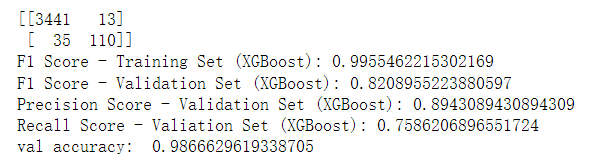

In [5]:
%pip install pandas 
%pip install matplotlib
%pip install pyarrow
%pip install imblearn
%pip install xgboost
%pip install catboost

# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [115]:
# Import necessary packages and functions for the code
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.utils import resample
from sklearn.feature_selection import mutual_info_regression

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file
filepath = "./data/catB_train.parquet" 

## EDA Code

### Exploratory Data Analysis code. It's key for understanding the data insights.

#### The section below is to read the dataset from the given parquet and understand the index and distribution of missing values.

By observing the nan_count_per_column data, we have a primary understanding of the missing value and try to fill most of the missing number by either the mode or the default meaningful number (i.e. 0 and 9999). We also create some flag columns to indicate some mass missing data (e.g. household data, identity data).

In [2]:
raw_df = pd.read_parquet(filepath)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)

#col_indexs = raw_df.columns
#index_list = col_indexs.tolist()
#print(index_list)

### Handle Missing values
nan_count_per_column = raw_df.isna().sum()
print(nan_count_per_column)

raw_df['race_desc'].fillna(value='Missing', inplace=True)
raw_df['ctrycode_desc'].fillna(value='Singapore', inplace=True)
raw_df = raw_df.drop('cltsex_fix', axis=1)
raw_df['missing_identity_data'] = raw_df['flg_substandard'].isna().astype(int)
raw_df['missing_household_data'] = raw_df['hh_20'].isna().astype(int)
raw_df['missing_lapse_data'] = raw_df['lapse_ape_ltc_1280bf'].isna().astype(int)
recency_columns = raw_df.filter(like='recency_')
raw_df[recency_columns.columns] = recency_columns.fillna(9999)
months_columns = raw_df.filter(like='n_months_since_')
raw_df[months_columns.columns] = months_columns.fillna(9999)

raw_df.fillna(value= 0 , inplace=True)

nan_count_per_column = raw_df.isna().sum()

clntnum                                  0
race_desc                             3996
ctrycode_desc                           20
clttype                                  0
stat_flag                                0
min_occ_date                             0
cltdob_fix                               0
cltsex_fix                              23
flg_substandard                       1014
flg_is_borderline_standard            1014
flg_is_revised_term                   1014
flg_is_rental_flat                    1014
flg_has_health_claim                  1014
flg_has_life_claim                    1014
flg_gi_claim                          1014
flg_is_proposal                       1014
flg_with_preauthorisation             1014
flg_is_returned_mail                  1014
is_consent_to_mail                    1014
is_consent_to_email                   1014
is_consent_to_call                    1014
is_consent_to_sms                     1014
is_valid_dm                           1014
is_valid_em

#### This section below is to handle categorical and other non-numerical data. 

We tried both LabelEncoding and OneHotEncoding, and carefully picked the more appropriate Encoding method for each categorical data.For most of the categorical data, there is no inherent order or ranking to the categorical data, hence we employ OneHotEncoding for those features. For the remaining categorical data, including 'hh_size_est' and 'annual_income_est', we created a map to encoding those categorical data while perserving the inherent order.

For the date data, we transform them into 'age' and 'years_since_first_buy' using the year of the date and 'first_buy_month' using the month of the date. We also tried to use a flag to indicate if any of the date is missing, however it turns out to be not helpful, and we deleted the flag columns in the end.

Along the way, we also realized that there are some non-date data in 'min_occ_date' and 'cltdob_fix' features. We deleted these non-date data and use KNN-imputers to fill the generated date-related columns (e.g. 'age' and 'first_buy_month').

In [19]:
print(raw_df.shape)
df_filled = raw_df
df_filled = df_filled.drop('clntnum', axis=1)
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False, drop='first')
categorical_columns = ['race_desc', 'stat_flag']
pd.get_dummies(df_filled, columns=categorical_columns)
df_filled = df_filled.drop(columns=categorical_columns)

df_filled['ctrycode_desc'] = df_filled['ctrycode_desc'].apply(lambda x: 1 if x == 'Singapore' else 0)
df_filled['clttype'] = label_encoder.fit_transform(df_filled['clttype'])
df_filled['missing_occ_date'] = df_filled['min_occ_date'].apply(lambda x: 1 if x == 'None' else 0)
df_filled['missing_dob_date'] = df_filled['cltdob_fix'].apply(lambda x: 1 if x == 'None' else 0)
df_filled['min_occ_date'] = df_filled['min_occ_date'].apply(lambda x: x if x != 'None' else None)
df_filled['min_occ_date'] = pd.to_datetime(df_filled['min_occ_date'])
df_filled['cltdob_fix'] = df_filled['cltdob_fix'].apply(lambda x: x if x != 'None' else None)
df_filled['cltdob_fix'] = pd.to_datetime(df_filled['cltdob_fix'])
#df_filled['missing_date_indicator'] = (df_filled[['missing_occ_date', 'missing_dob_date']] == 1).any(axis=1).astype(int)

df_filled['years_since_first_buy'] = 2024 - df_filled['min_occ_date'].dt.year
df_filled['age'] = 2024 - df_filled['cltdob_fix'].dt.year
df_filled['first_buy_month'] = df_filled['min_occ_date'].dt.month

df_filled = df_filled.drop('min_occ_date', axis=1)
df_filled = df_filled.drop('cltdob_fix', axis=1)

df_filled['hh_size_est'] = df_filled['hh_size_est'].apply(lambda x: 5 if x == '>4' else int(x))

hh_size_est_mapping = {'E.BELOW30K': 0, 'D.30K-60K': 1, 'C.60K-100K': 2, 'B.100K-200K':3, 'A.ABOVE200K':4}
df_filled['annual_income_est'] = df_filled['annual_income_est'].map(hh_size_est_mapping)

for col in df_filled.columns:
    if pd.api.types.is_object_dtype(df_filled[col]):
        df_filled[col] = pd.to_numeric(df_filled[col], errors='ignore')

imputer = KNNImputer(n_neighbors=5)
df_filled = pd.DataFrame(imputer.fit_transform(df_filled), columns=df_filled.columns)

non_numerical_columns = df_filled.select_dtypes(include=['object'])
# Display the columns with non-numerical values
print("Columns with non-numerical values:")
print(non_numerical_columns.columns)

df_save=df_filled

(17992, 306)
Columns with non-numerical values:
Index([], dtype='object')


#### This section below is to drop irrelevant or intermediate columns and handle product-related columns.

We dropped most of the household data and only kept the 'hh_size_est' as a representative of this type of data.

We also handle the product-related data by mainly 2 ways. First, we calculated the sum of ape (non_lapse and lapse) and prempaid for each customer, and dropped the specific non_lapse_ape, sumins, and prempaid columns for each product.

Second, we attempted to combine the 'n_months_last_bought' and 'n_months_since_lapse'. Initially we tried to create a indicator column for each type of product (e.g. lh, inv, grp) to indicate if the customer has ever bought or lapse this type of product. However, this way of creating new feature is not very helpful and we changed to 'n_months_last_bought' columns for each type of products by taking the min value of relevant columns for all the products of that type. In addition, since the purpose of this model is to predict lh product, we also specifically group the products as 'lh' and 'non_lh' to better highlight the stats related to lh.

In [20]:
#Drop some less meaningful columns
df_filled = df_filled.drop('hh_20', axis=1)
df_filled = df_filled.drop('pop_20', axis=1)
df_filled = df_filled.drop('hh_size', axis=1)

ape_columns = df_filled.filter(like='ape')
non_lapse_ape_columns = ape_columns[ape_columns.columns.drop(list(ape_columns.filter(regex='lapse')))]
df_filled['ape_sum'] = non_lapse_ape_columns.sum(axis=1)
df_filled['lapse_ape_sum'] = df_filled.filter(like='lapse_ape').sum(axis=1)

prempaid_columns = df_filled.filter(like='prempaid')
df_filled['prempaid_sum'] = prempaid_columns.sum(axis=1)

df_filled = df_filled.drop(columns=non_lapse_ape_columns.columns)
df_filled = df_filled.drop(columns=df_filled.filter(like='sumins').columns)
#df_filled = df_filled.drop(columns=df_filled.filter(like='ever_bought').columns)
df_filled = df_filled.drop(columns=df_filled.filter(like='prempaid').columns)

bought_columns = df_filled.filter(like='n_months_last_bought')
lapse_columns = df_filled.filter(like='n_months_since_lapse')
bought_columns = bought_columns[bought_columns.columns.drop(list(bought_columns.filter(regex='n_months_last_bought_products')))]
print(bought_columns.shape)

lh_bought_columns = bought_columns.filter(like = 'lh')
lh_lapse_columns = lapse_columns.filter(like = 'lh')
print(lh_bought_columns.shape)

df_filled['bought_indicator'] = (bought_columns != 9999).any(axis=1).astype(int)
df_filled['lapse_indicator'] = (lapse_columns != 9999).any(axis=1).astype(int)
#df_filled['lh_bought_indicator'] = (lh_bought_columns != 9999).any(axis=1).astype(int)
#df_filled['lh_lapse_indicator'] = (lh_lapse_columns != 9999).any(axis=1).astype(int)
df_filled['n_months_last_bought_lh'] = lh_bought_columns.min(axis=1)
df_filled['n_months_last_lapse_lh'] = lh_lapse_columns.min(axis=1)

df_filled['n_months_last_bought_grp'] = bought_columns.filter(like = 'grp').min(axis=1)
df_filled['n_months_last_lapse_grp'] = lapse_columns.filter(like = 'grp').min(axis=1)

df_filled['n_months_last_bought_inv'] = bought_columns.filter(like = 'inv').min(axis=1)
df_filled['n_months_last_lapse_inv'] = lapse_columns.filter(like = 'inv').min(axis=1)

df_filled['n_months_last_lapse_ltc'] = lapse_columns.filter(like = 'ltc').min(axis=1)

non_lh_bought_columns = bought_columns[bought_columns.columns.drop(list(bought_columns.filter(regex='lh')))]
non_lh_lapse_columns = lapse_columns[lapse_columns.columns.drop(list(lapse_columns.filter(regex='lh')))]


df_filled['non_lh_bought_indicator'] = non_lh_bought_columns.min(axis=1)
df_filled['non_lh_lapse_indicator'] = non_lh_lapse_columns.min(axis=1)

df_save = df_filled

(17992, 32)
(17992, 6)


#### This section below is to combine columns with similar meanings to create indicator columns which captures more high level details.

The detailed explanation can be found in A quick go through > new features.

In [21]:
##Combine some columns with similar meaning

df_filled = df_save
#Combine 'consent' columns
consent_columns = df_filled.filter(like='is_consent_to')
df_filled['consent_indicator'] = np.log(consent_columns.sum(axis=1)+1)
#df_filled = df_filled.drop(columns=consent_columns.columns)

#Combine 'is_valid_ columns
valid_columns = df_filled.filter(like='is_valid')
df_filled['valid_indicator'] = np.log(valid_columns.sum(axis=1)+1)
#df_filled = df_filled.drop(columns=valid_columns.columns)

#Combine 'hlthclaim' columns
#Formula: log ( 'hlthclaim_cnt_success' + 2 ) * (0.99 * ( 'hlthclaim_amt' + 2)) * (0.99 **  'recency_hlthclaim' )
df_filled['success_hlthclaim_indicator'] = np.log(df_filled['hlthclaim_cnt_success'] + 2)\
    *np.power(0.99, -np.log(df_filled['hlthclaim_amt']+2))*np.power(0.99, df_filled['recency_hlthclaim'])
df_filled['unsuccess_hlthclaim_indicator'] = np.log(df_filled['hlthclaim_cnt_unsuccess'] + 2)*np.power(0.99, df_filled['recency_hlthclaim'])
df_filled = df_filled.drop('hlthclaim_cnt_success', axis=1)
df_filled = df_filled.drop('hlthclaim_cnt_unsuccess', axis=1)
df_filled = df_filled.drop('hlthclaim_amt', axis=1)
df_filled = df_filled.drop('recency_hlthclaim', axis=1)

#Combine 'giclaim' columns
#Formula: log ( 'giclaim_amt' + 2 ) * (0.99 **  'recency_giclaim' )
df_filled['giclaim_indicator'] = np.log(df_filled['giclaim_amt']+2)*np.power(0.99, df_filled['recency_giclaim'])
df_filled = df_filled.drop('giclaim_amt', axis=1)
df_filled = df_filled.drop('recency_giclaim', axis=1)

#LTC indicator
df_filled['LTC_indicator'] = ((df_filled['age'] >= 65).astype(int)) * (1 -((df_filled[['f_ever_bought_ltc_1280bf', 'f_ever_bought_ltc_43b9d5']]==1).any(axis=1).astype(int) * (df_filled['n_months_since_lapse_ltc_1280bf']==9999).astype(int) * (df_filled['n_months_since_lapse_ltc_43b9d5']==9999).astype(int)))
df_filled = df_filled.drop(columns=df_filled.filter(like='ever_bought').columns)

#### This section below is to ensure that we did not generate any unexpected infinity value in our self-defined features.

In [ ]:
#nan_count_per_column = df_filled.isna().sum()
#print(df_filled.max(axis=0))
columns_with_infinity = df_filled.columns[np.any(np.isinf(df_filled), axis=0)]

print("Columns with infinity values:", columns_with_infinity)

#### This section below is to delete single value columns.

Initially we tried to delete columns with small variance, however, this might not improve the performance as the target columns is dominated by 0 and also have small variance. Hence, we decided to delete only single value columns instead.

In [22]:
##Drop some columns with low variance

#variance_threshold = 0.01
#variances = df_filled.var()
#low_variance_columns = variances[variances <= variance_threshold].index
#column_target = df_filled['f_purchase_lh']
#df_filled = df_filled.drop(columns=low_variance_columns)

single_value_columns = df_filled.columns[df_filled.nunique() == 1]
df_filled = df_filled.drop(columns=single_value_columns)

#### This section below is to investigate mutual information between target columns and other columns.

We observed from the plot that a few 'lapse_ape' columns and 'n_month_since_lapse' columns are comparatively more informative of the target column. This is one of the reasons that inspired us to look into lapse-related variables. 

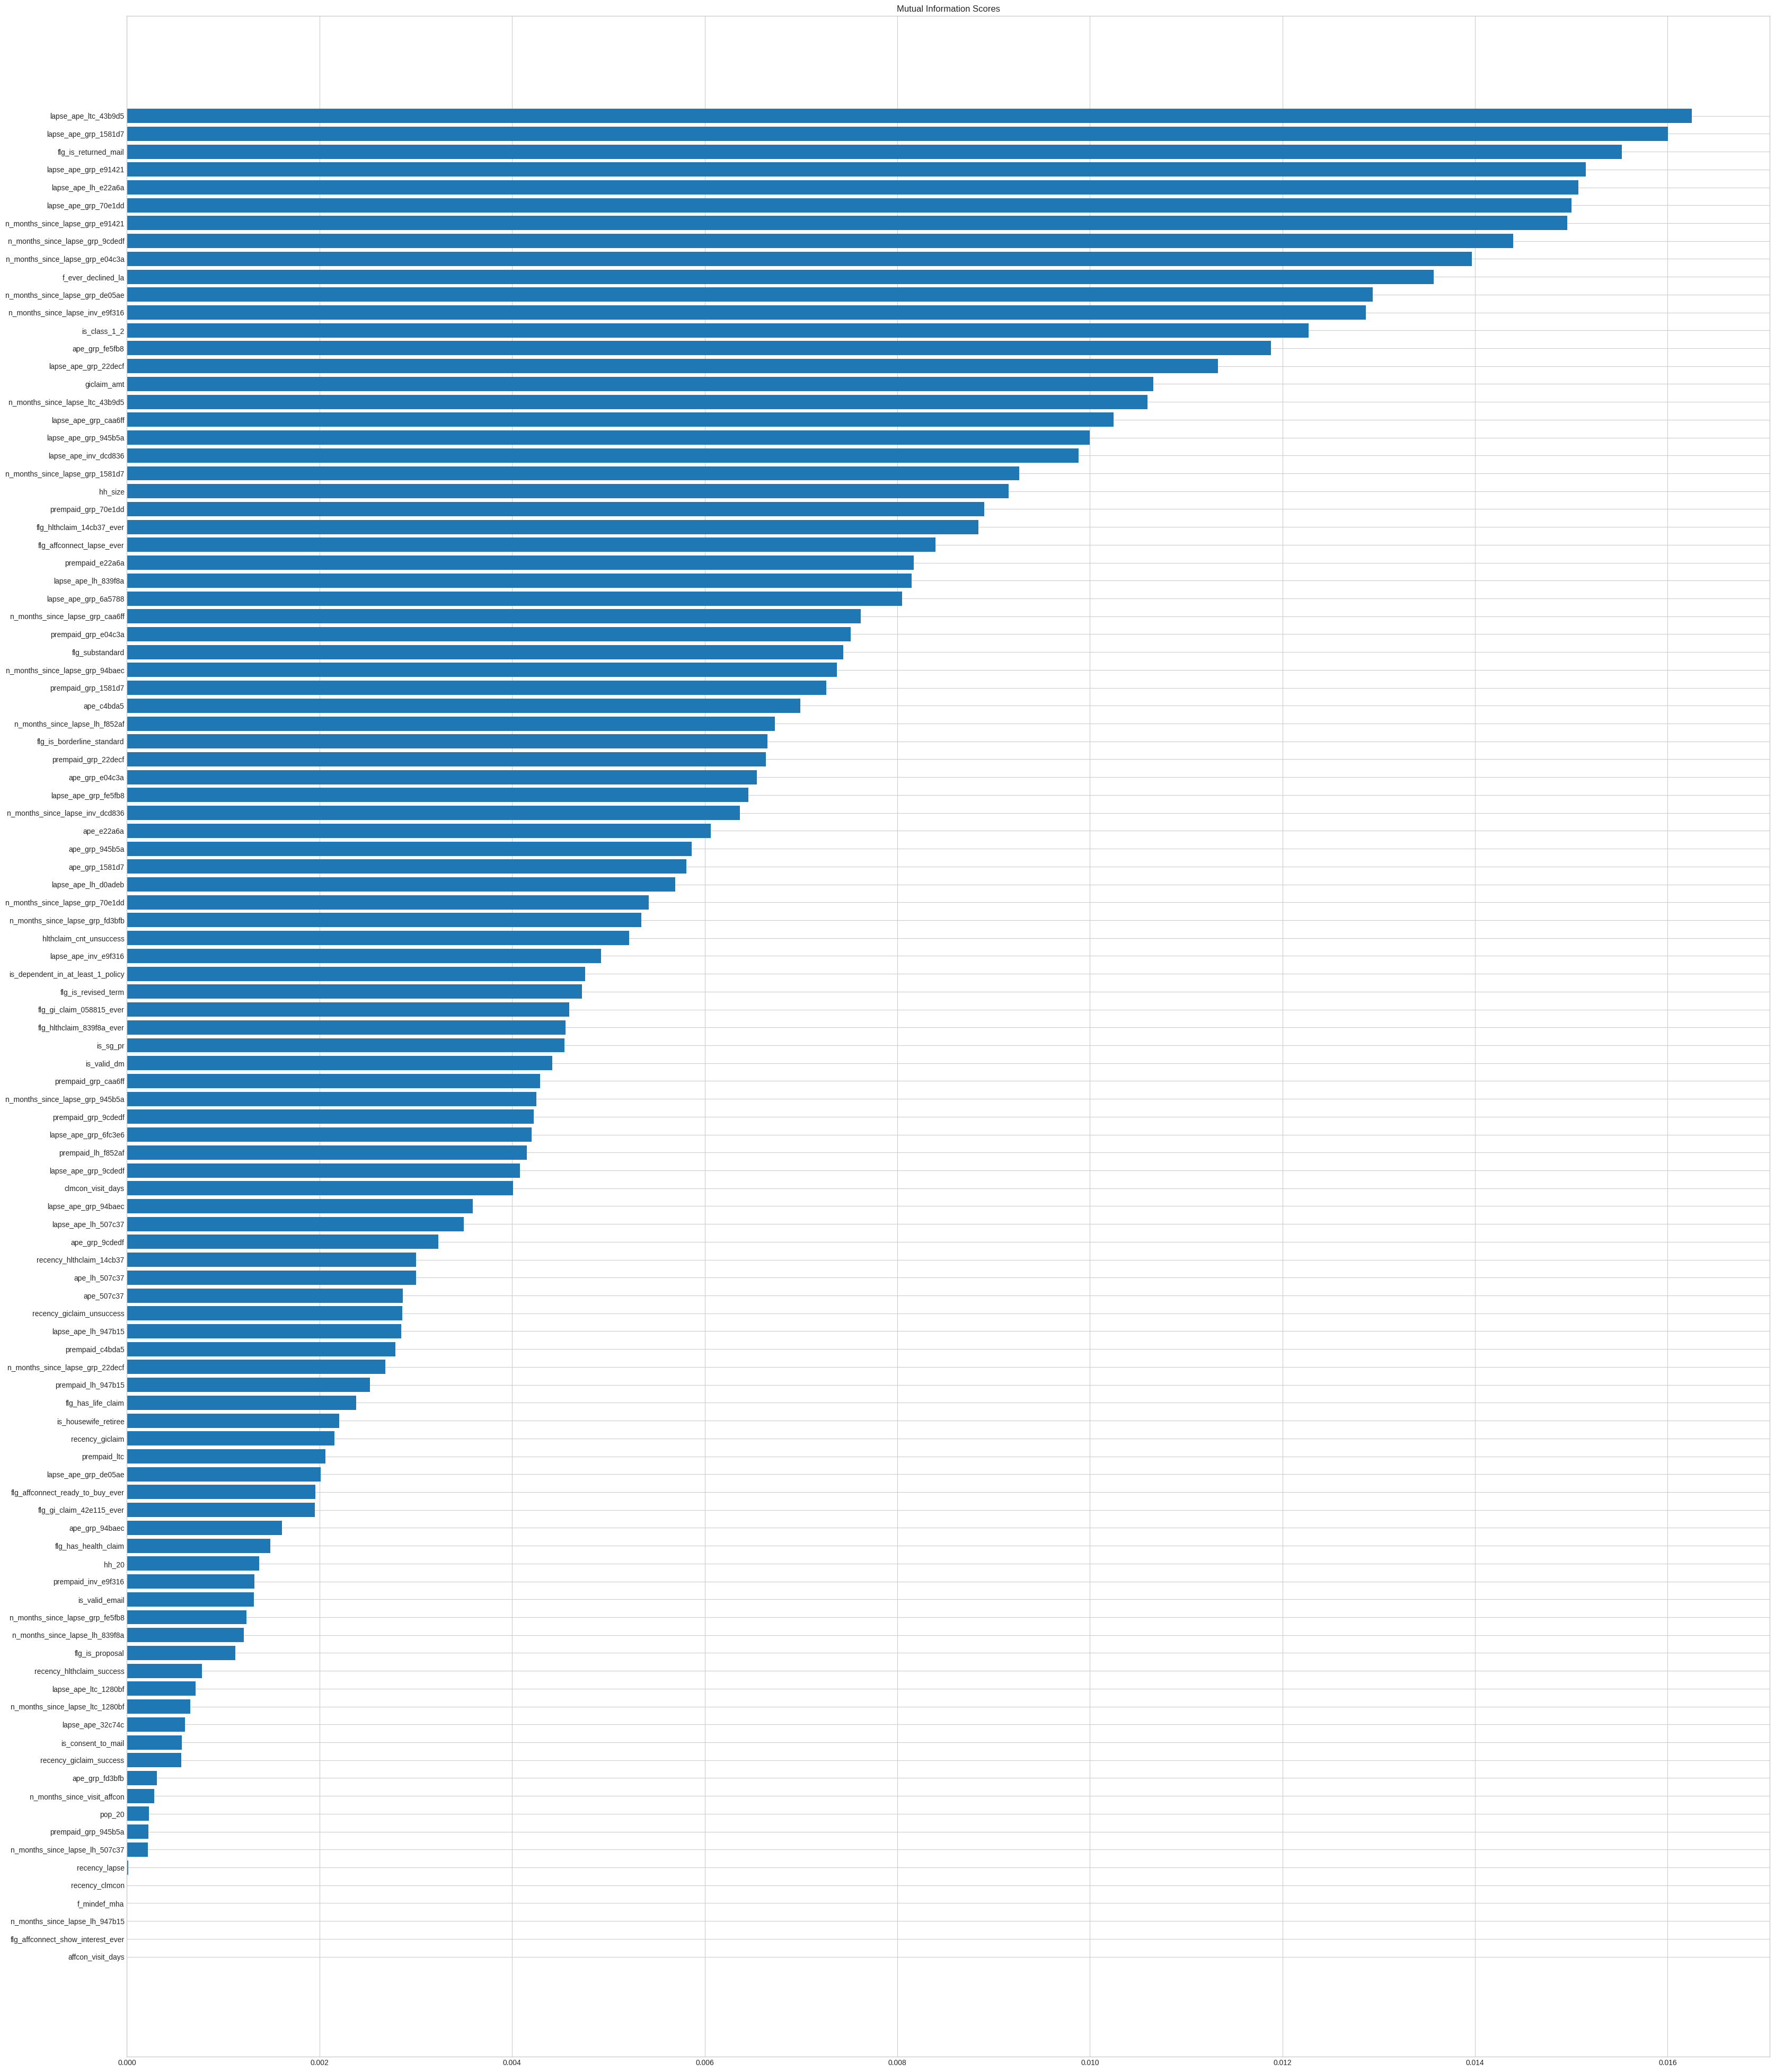

In [ ]:
plt.style.use("seaborn-whitegrid")

X = df_filled.copy()
y = X.pop("f_purchase_lh")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int
X1 = X.notnull()
y1 = y.notnull()

def make_mi_scores(X1, y1, discrete_features):
    mi_scores = mutual_info_regression(X1, y1, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X1.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X1, y1, discrete_features)
mi_scores[::3]  # Show a few features with their MI scores

# Plotting the graph
length = len(mi_scores)
print(length)

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    scores = scores[200:]
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(dpi=100, figsize=(40, 50))
plot_mi_scores(mi_scores)

#### This section below is to investigate correlation between target columns and other columns.

This can be used to double check if our self-defined feature is meaningful. We also used it to find less correlated columns for us to combine together to form a more correlated column.

In [7]:
column_target = df_filled['f_purchase_lh']

#print(non_lh_bought_columns.info)
print(df_filled['LTC_indicator'].value_counts())

# Calculate the correlation with all other columns
correlation_with_target = df_filled.corrwith(column_target)

# Sort the correlation values
sorted_correlation = correlation_with_target.sort_values(ascending=False)
sorted_correlation

0    16585
1     1407
Name: LTC_indicator, dtype: int64


f_purchase_lh                        1.000000
flg_gi_claim                         0.141924
valid_indicator                      0.123803
giclaim_indicator                    0.114943
flg_latest_being_lapse               0.095357
tot_inforce_pols                     0.091541
f_mindef_mha                         0.090372
f_hold_839f8a                        0.084588
flg_affconnect_ready_to_buy_ever     0.080874
is_class_1_2                         0.074700
tot_cancel_pols                      0.072357
clttype                              0.067219
flg_affconnect_show_interest_ever    0.065390
f_hold_507c37                        0.064114
is_sg_pr                             0.063547
flg_is_proposal                      0.060620
f_ever_declined_la                   0.058014
is_housewife_retiree                 0.056723
bought_indicator                     0.054122
f_retail                             0.046370
hh_size_est                          0.045190
affcon_visit_days                 

#### This section below is to delete columns with small correlation with target.

In this section, we tried to adjust the threshold value to achieve a balance between keeping useful information and deleting noise. By numerous experiments, 0.015 seems to be a good choice.

In [23]:
##Delete columns with small corr with target
correlation_threshold = 0.015
correlations = df_filled.corr()['f_purchase_lh'].abs()
low_corr_columns = correlations[correlations < correlation_threshold].index
# Drop columns with low correlation
df_filled = df_filled.drop(columns=low_corr_columns)
print(df_filled.shape)

(17992, 97)


#### This section below is to visualize the correlation between columns.

We also filtered columns whose names are closely related to each other and visualized the correlation to see if there is any pattern.

Here is an example:<br>
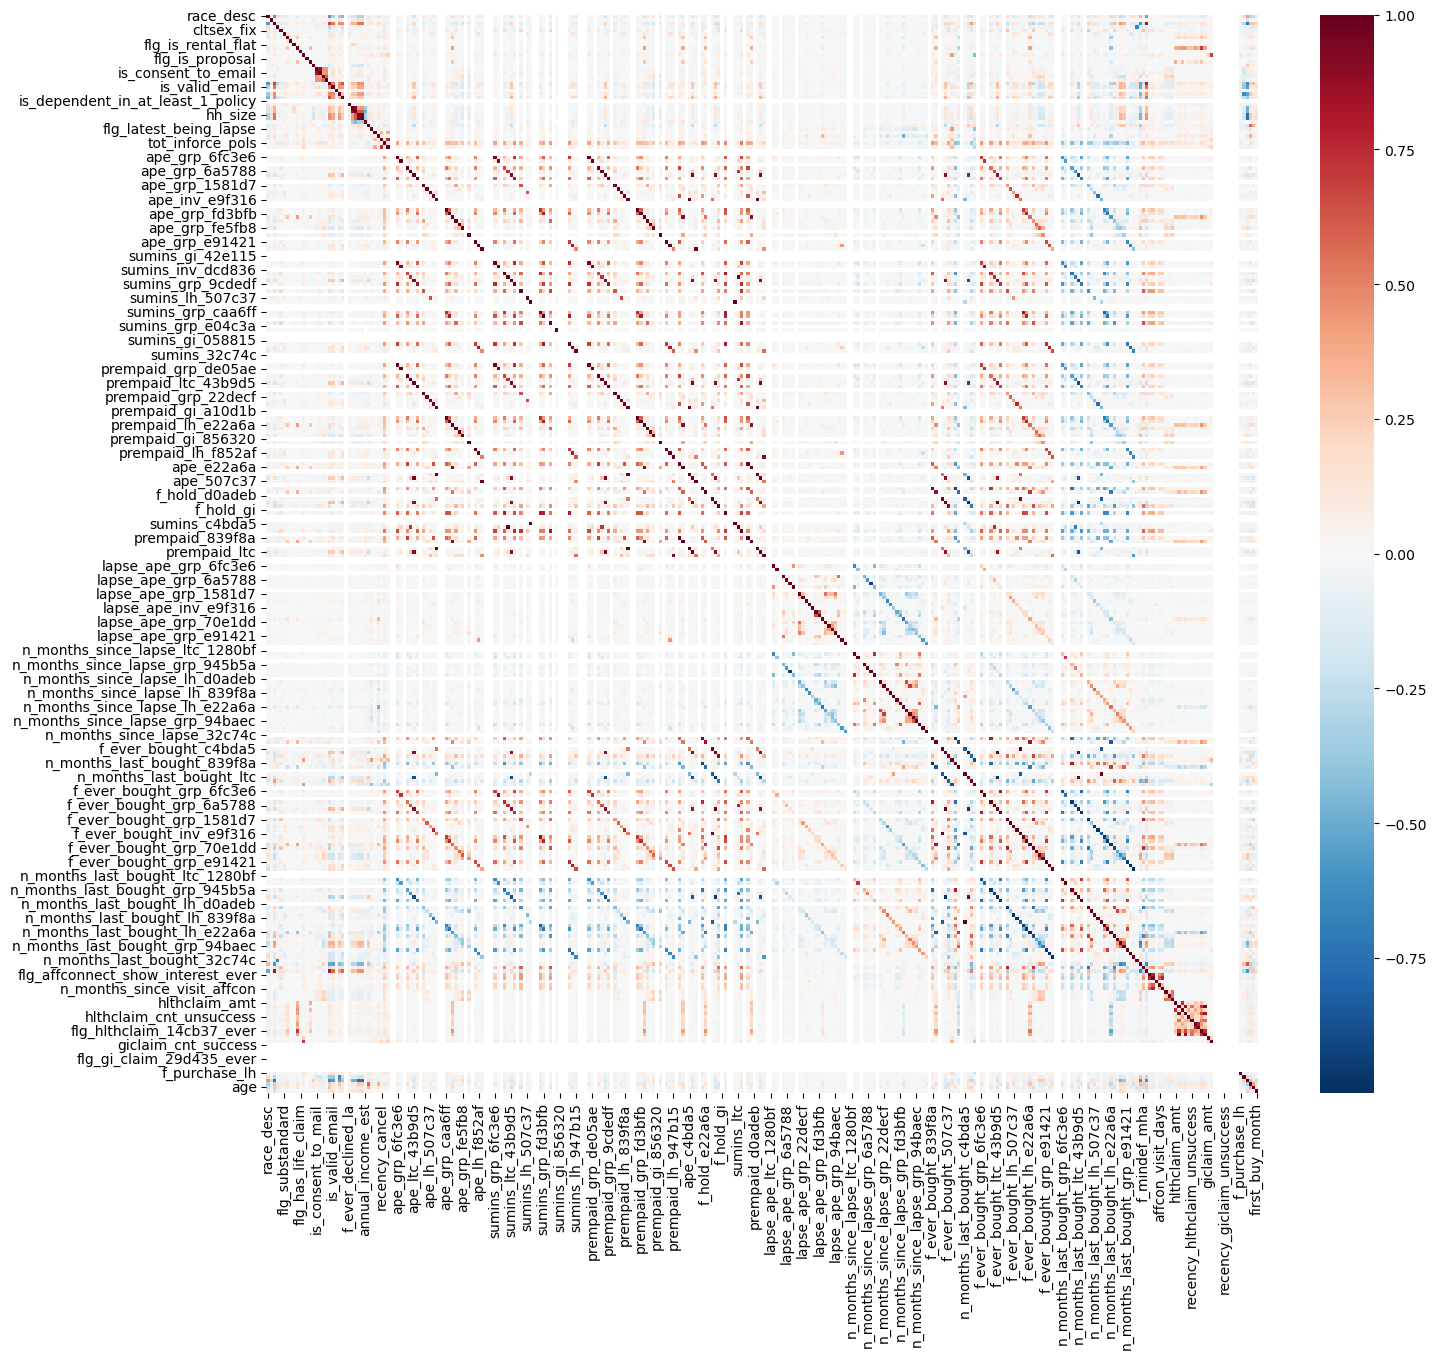 <br>
By observing this graph, we noticed that there are many minor diagonals, by inspecting carefully, we realized that many features of one specific product are closely correlated together and could be combined together.

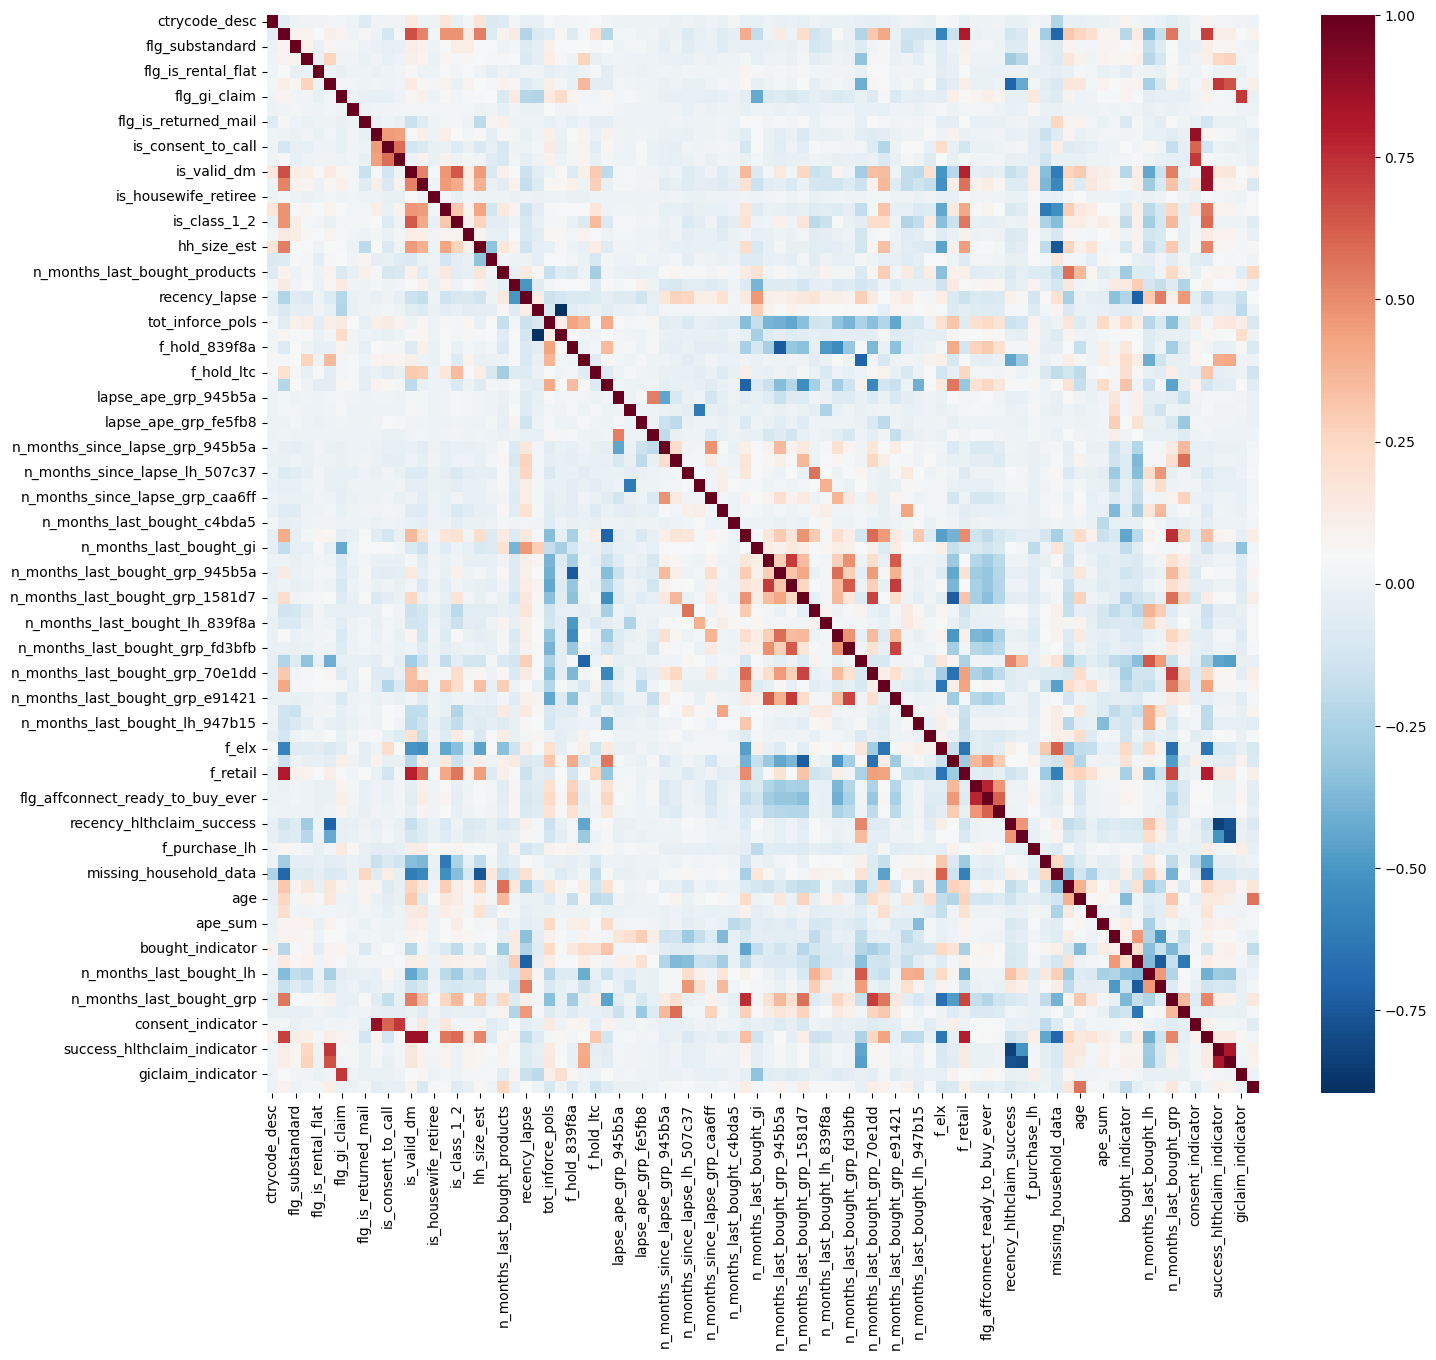

In [57]:
# find columns' correlation
#df_839 = df_filled.filter(like='6fc3e6')
corr_matrix = df_filled.corr()

plt.figure(figsize = (16, 14))
sns.heatmap(corr_matrix, cmap='RdBu_r')
plt.show()

#### This section below is to delete columns with high correlation with each other.

In [24]:
##Delete columns with high correlation with each other and keep only one of them
correlation_matrix = df_filled.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))

# Find columns with correlation above a certain threshold
threshold = 0.9  # Adjust this threshold based on your requirements
highly_correlated_columns = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

# Keep only one column from each highly correlated pair
df_filled = df_filled.drop(columns=highly_correlated_columns)
print(df_filled.shape)

(17992, 86)


C:\Users\lsq69.PC-20230731LVFT\AppData\Local\Temp\ipykernel_24120\344104886.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))


#### This section below is to delete columns with small p_value.

In [25]:
#Drop columns with small p_value

model = LinearRegression()

results = pd.DataFrame(columns = ['Feature', 'R_squared', 'P_value'])

for col in df_filled.columns:
    if col != 'f_purchase_lh':
        X = df_filled[[col]]
        y = df_filled['f_purchase_lh']
        
        model.fit(X, y)
        
        # r-value
        r_squared = model.score(X, y)
        # p-value
        X_sm = sm.add_constant(X)
        model_sm = sm.OLS(y, X_sm).fit()
        p_value = model_sm.pvalues[col]

        results = results.append({'Feature': col, 'R_squared': r_squared, 'P_value': p_value}, 
                             ignore_index=True)
results = results.sort_values(by = ['R_squared'], axis = 0, ascending = False)
significant_features = results[results['P_value'] < 0.05]['Feature']
#significant_features = ["n_months_last_bought_gi","flg_gi_claim","valid_indicator","recency_lapse","giclaim_indicator","flg_latest_being_lapse","tot_inforce_pols","f_mindef_mha","f_hold_839f8a","flg_affconnect_ready_to_buy_ever","n_months_last_bought_grp_caa6ff","n_months_last_bought_products","recency_cancel","is_class_1_2","tot_cancel_pols","missing_household_data","n_months_last_bought_grp_1581d7","clttype","flg_affconnect_show_interest_ever","f_hold_507c37","is_sg_pr","n_months_last_bought_grp_9cdedf","n_months_last_bought_lh","flg_is_proposal","n_months_last_bought_grp_945b5a","f_ever_declined_la","n_months_last_bought_lh_839f8a","is_housewife_retiree","n_months_last_bought_grp_70e1dd","n_months_last_bought_grp_6fc3e6","bought_indicator","n_months_last_bought_grp_e91421","n_months_last_bought_lh_f852af","f_retail","hh_size_est","affcon_visit_days","n_months_last_bought_grp_fd3bfb","ape_sum","age","n_months_last_bought_507c37","annual_income_est","f_elx","missing_identity_data","n_months_last_bought_lh_947b15","lapse_indicator","flg_substandard","n_months_since_lapse_grp_caa6ff","years_since_first_buy","n_months_last_bought_lh_507c37","n_months_last_bought_lh_e22a6a","consent_indicator","lapse_ape_lh_839f8a","n_months_last_lapse_grp","f_hold_ltc","recency_hlthclaim_success","n_months_last_bought_grp","unsuccess_hlthclaim_indicator","n_months_since_lapse_lh_839f8a","n_months_last_bought_grp_fe5fb8","lapse_ape_grp_e91421","first_buy_month","n_months_last_bought_32c74c","recency_hlthclaim_unsuccess","LTC_indicator","n_months_last_lapse_lh","n_months_since_lapse_lh_507c37","ctrycode_desc","lapse_ape_grp_fe5fb8","success_hlthclaim_indicator","flg_is_borderline_standard","flg_is_returned_mail","n_months_since_lapse_grp_1581d7","n_months_since_lapse_grp_945b5a","lapse_ape_grp_945b5a","f_hold_e22a6a","flg_is_rental_flat","flg_has_health_claim","n_months_last_bought_c4bda5","n_months_since_lapse_lh_f852af"]
print(list(significant_features))
df_filled_selected = df_filled[list(significant_features)]

C:\Users\lsq69.PC-20230731LVFT\AppData\Local\Temp\ipykernel_24120\1405882692.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Feature': col, 'R_squared': r_squared, 'P_value': p_value},
C:\Users\lsq69.PC-20230731LVFT\AppData\Local\Temp\ipykernel_24120\1405882692.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Feature': col, 'R_squared': r_squared, 'P_value': p_value},
C:\Users\lsq69.PC-20230731LVFT\AppData\Local\Temp\ipykernel_24120\1405882692.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Feature': col, 'R_squared': r_squared, 'P_value': p_value},
C:\Users\lsq69.PC-20230731LVFT\AppData\Local\Temp\ipykernel_24120\1405882692.py:21

C:\Users\lsq69.PC-20230731LVFT\AppData\Local\Temp\ipykernel_24120\1405882692.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Feature': col, 'R_squared': r_squared, 'P_value': p_value},
C:\Users\lsq69.PC-20230731LVFT\AppData\Local\Temp\ipykernel_24120\1405882692.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Feature': col, 'R_squared': r_squared, 'P_value': p_value},
C:\Users\lsq69.PC-20230731LVFT\AppData\Local\Temp\ipykernel_24120\1405882692.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Feature': col, 'R_squared': r_squared, 'P_value': p_value},
C:\Users\lsq69.PC-20230731LVFT\AppData\Local\Temp\ipykernel_24120\1405882692.py:21

['n_months_last_bought_gi', 'flg_gi_claim', 'valid_indicator', 'recency_lapse', 'is_valid_email', 'giclaim_indicator', 'is_valid_dm', 'flg_latest_being_lapse', 'tot_inforce_pols', 'f_mindef_mha', 'f_hold_839f8a', 'flg_affconnect_ready_to_buy_ever', 'n_months_last_bought_grp_caa6ff', 'n_months_last_bought_products', 'recency_cancel', 'is_class_1_2', 'tot_cancel_pols', 'missing_household_data', 'n_months_last_bought_grp_1581d7', 'clttype', 'flg_affconnect_show_interest_ever', 'f_hold_507c37', 'is_sg_pr', 'n_months_last_bought_grp_9cdedf', 'n_months_last_bought_lh', 'flg_is_proposal', 'n_months_last_bought_grp_945b5a', 'f_ever_declined_la', 'n_months_last_bought_lh_839f8a', 'is_housewife_retiree', 'n_months_last_bought_grp_70e1dd', 'n_months_last_bought_grp_6fc3e6', 'bought_indicator', 'n_months_last_bought_grp_e91421', 'is_consent_to_call', 'n_months_last_bought_lh_f852af', 'is_consent_to_mail', 'f_retail', 'hh_size_est', 'affcon_visit_days', 'n_months_last_bought_grp_fd3bfb', 'ape_sum',

C:\Users\lsq69.PC-20230731LVFT\AppData\Local\Temp\ipykernel_24120\1405882692.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Feature': col, 'R_squared': r_squared, 'P_value': p_value},
C:\Users\lsq69.PC-20230731LVFT\AppData\Local\Temp\ipykernel_24120\1405882692.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Feature': col, 'R_squared': r_squared, 'P_value': p_value},
C:\Users\lsq69.PC-20230731LVFT\AppData\Local\Temp\ipykernel_24120\1405882692.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Feature': col, 'R_squared': r_squared, 'P_value': p_value},
C:\Users\lsq69.PC-20230731LVFT\AppData\Local\Temp\ipykernel_24120\1405882692.py:21

#### This section below is to explore the effect of scaling and PCA.

We also tried several scaling methods, including MinMaxScaling and StandardScaling. However, since we are using XGBTree, scaling does not necessarily helpful.

In addition, we also tried PCA to further filter the features. However, by experimentation, the effect is not good.

As a result, we did not include this section in our final model.

In [ ]:
#Perform PCA
df = df_filled
y = df_filled['f_purchase_lh']
X = df_filled_selected

scaler = MinMaxScaler()
X_standardized = scaler.fit_transform(X)

# Choose the number of components for PCA
n_components = 60  # You can choose a different number based on your requirements

# Perform PCA
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(n_components)])
pca_df

#### The two sections below is to rebalance the data.

We tried two ways to rebalance the data. One is SMOTE and it turns out to work well.

The other one we tried is a mix of upsampling and downsasmpling. However, its performance is much worse than SMOTE and thus we picked SMOTE in our final model.

In [75]:
#Rebalance using up and down sampling
df = df_filled
y = df['f_purchase_lh']
X = df.drop('f_purchase_lh', axis=1)

X_train, X_val, y_train, y_val = train_test_split(pca_df, y, test_size=0.2, random_state=21)

train = pd.concat([X_train, y_train], axis = 1)
majority_class = train[train['f_purchase_lh'] == 0]
minority_class = train[train['f_purchase_lh'] == 1]

minority_upsampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)
balanced_df = pd.concat([majority_class, minority_upsampled])

y_train = balanced_df['f_purchase_lh']
X_train = balanced_df.drop('f_purchase_lh', axis=1)

NameError: name 'pca_df' is not defined

In [102]:
## Rebalance using SMOTE
df = df_filled
y = df_filled['f_purchase_lh'] 
X = df_filled_selected


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

print('Before:', Counter(y_train))
smo = SMOTE(sampling_strategy=1)
#X_train, y_train = smo.fit_resample(X_train, y_train)
X, y = smo.fit_resample(X, y)
print('After:', Counter(y_val))

Before: Counter({0.0: 13833, 1.0: 560})
After: Counter({0.0: 3449, 1.0: 150})


#### The several sections below is to explore the effect of various model.

We tried Gradient Boosting, Random Forest, SVM, Decision Tree, LR, NN, and Gradient Boosting has the best performance.

After we selecting Gradient Boosting, we also tried XGBoost and CatBoost models. By many experimentations, XGBoost has the best performance and we decided to use this as our final model.

In [103]:
## Try XGBoost
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

class_weights_dict = {0: 0.52, 1: 1.75}
#sample_weights = np.array([class_weights_dict[i] for i in y_train])
sample_weights = np.array([class_weights_dict[i] for i in y])

import xgboost as xgb
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split


# Creating an XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    max_depth=3,
    learning_rate=0.01,
    n_estimators=2250,
    colsample_bytree=0.45,
    subsample=0.65,
    reg_alpha=2,
    random_state=42
)

# Training the model
#xgb_clf.fit(X_train, y_train, sample_weight=sample_weights, eval_metric="logloss", verbose=True)
xgb_clf.fit(X, y, sample_weight=sample_weights, eval_metric="aucpr", verbose=True)

# Predictions on training set
y_train_pred_xgb = xgb_clf.predict(X_train)
#y_train_pred_xgb = xgb_clf.predict(X)

# Predictions on validation set
y_val_pred_xgb = xgb_clf.predict(X_val)

# Calculate the F1 score for training set
f1_train_xgb = f1_score(y_train, y_train_pred_xgb)

# Calculate the F1 score for validation set
f1_val_xgb = f1_score(y_val, y_val_pred_xgb)

cm = confusion_matrix(y_val, y_val_pred_xgb)

print(cm)

print("F1 Score - Training Set (XGBoost):", f1_train_xgb)
print("F1 Score - Validation Set (XGBoost):", f1_val_xgb)
print("Precision Score - Validation Set (XGBoost):", precision_score(y_val, y_val_pred_xgb))
print("Recall Score - Valiation Set (XGBoost):",recall_score(y_val, y_val_pred_xgb))
print("val accuracy: ", xgb_clf.score(X_val, y_val))

C:\ProgramData\anaconda3\envs\CS2109S\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[[3368   81]
 [  86   64]]
F1 Score - Training Set (XGBoost): 0.42538593481989706
F1 Score - Validation Set (XGBoost): 0.4338983050847457
Precision Score - Validation Set (XGBoost): 0.4413793103448276
Recall Score - Valiation Set (XGBoost): 0.4266666666666667
val accuracy:  0.9535982217282578


In [ ]:
#Try Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

rndforest_clf = RandomForestClassifier()
rndforest_clf.fit(X_train, y_train)

# Predictions on training set
y_train_pred_rnd = rndforest_clf.predict(X_train)

# Predictions on validation set
y_val_pred_rnd = rndforest_clf.predict(X_val)

# Calculate the F1 score for training set
f1_train_rnd = f1_score(y_train, y_train_pred_rnd)

# Calculate the F1 score for validation set
f1_val_rnd = f1_score(y_val, y_val_pred_rnd)

print("F1 Score - Training Set:", f1_train_rnd)
print("F1 Score - Validation Set:", f1_val_rnd)


In [ ]:
##Try Gradient Boosting

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, confusion_matrix

boosted_clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators = 500, max_depth=6)
boosted_clf.fit(X_train, y_train)

# Predictions on training set
y_train_pred_boosted = boosted_clf.predict(X_train)

# Predictions on validation set
y_val_pred_boosted = boosted_clf.predict(X_val)

unique_elements, counts = np.unique(y_val_pred_boosted, return_counts=True)

# Create a dictionary to store the counts for each element
element_counts = dict(zip(unique_elements, counts))

print(element_counts)

# Calculate the F1 score for training set
f1_train_boosted = f1_score(y_train, y_train_pred_boosted, average = 'binary')

# Calculate the F1 score for validation set
f1_val_boosted = f1_score(y_val, y_val_pred_boosted, average = 'binary')
cm = confusion_matrix(y_val, y_val_pred_boosted)

print(cm)

print("F1 Score - Training Set (Boosted):", f1_train_boosted)
print("F1 Score - Validation Set (Boosted):", f1_val_boosted)

print("train accuracy: ", boosted_clf.score(X_train, y_train))
print("val accuracy: ", boosted_clf.score(X_val, y_val))

# Cross validation (codes from workshop jupyter notebook)
from sklearn.model_selection import cross_val_score

model = boosted_clf
scores = cross_val_score(model, X, y, cv=5)

# By default, cross_val_score returns a numpy array of accurcacies for each train-test split
#>>> scores
#array([0.96..., 1. , 0.96..., 0.96..., 1. ])

# To use other metrics for example, f1-macro score:
from sklearn import metrics

scores = cross_val_score(model, X, y, cv=5, scoring='f1_micro')
scores

In [ ]:
##Try NN

from sklearn.neural_network import MLPClassifier

nn_clf = MLPClassifier()
nn_clf.fit(X_train, y_train)

# Predictions on training set
y_train_pred_nn = nn_clf.predict(X_train)

# Predictions on validation set
y_val_pred_nn = nn_clf.predict(X_val)

# Calculate the F1 score for training set
f1_train_nn = f1_score(y_train, y_train_pred_nn)

# Calculate the F1 score for validation set
f1_val_nn = f1_score(y_val, y_val_pred_nn)

print("F1 Score - Training Set (Neural Network):", f1_train_nn)
print("F1 Score - Validation Set (Neural Network):", f1_val_nn)
#print("train accuracy: ", nn_clf.score(X_train, y_train))
#print("val accuracy: ", nn_clf.score(X_val, y_val))


In [ ]:
##Try LR

from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)
# Predictions on training set
y_train_pred_log = log_clf.predict(X_train)

# Predictions on validation set
y_val_pred_log = log_clf.predict(X_val)

# Calculate the F1 score for training set
f1_train_log = f1_score(y_train, y_train_pred_log)

# Calculate the F1 score for validation set
f1_val_log = f1_score(y_val, y_val_pred_log)

print("F1 Score - Training Set (Logistic Regression):", f1_train_log)
print("F1 Score - Validation Set (Logistic Regression):", f1_val_log)


#print("train accuracy: ", log_clf.score(X_train, y_train))
#print("val accuracy: ", log_clf.score(X_val, y_val))

In [ ]:
##Try SVM

from sklearn.svm import SVC

svm_clf = SVC(C=1)
svm_clf.fit(X_train, y_train)

# Predictions on training set
y_train_pred_svm = svm_clf.predict(X_train)

# Predictions on validation set
y_val_pred_svm = svm_clf.predict(X_val)

# Calculate the F1 score for training set
f1_train_svm = f1_score(y_train, y_train_pred_svm)

# Calculate the F1 score for validation set
f1_val_svm = f1_score(y_val, y_val_pred_svm)

print("F1 Score - Training Set (SVM):", f1_train_svm)
print("F1 Score - Validation Set (SVM):", f1_val_svm)

print("train accuracy: ", svm_clf.score(X_train, y_train))
print("val accuracy: ", svm_clf.score(X_val, y_val))


In [51]:
#Try CatBoost

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

class_weights_dict = {0: 0.52, 1: 1.75}
sample_weights = np.array([class_weights_dict[i] for i in y_train])

import catboost as cb
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import train_test_split

# Creating an CatBoost classifier
cb_clf = cb.CatBoostClassifier(
    eval_metric = 'F1',
    l2_leaf_reg = 0.5,
    subsample=0.8, 
    min_data_in_leaf= 1,
    learning_rate=0.1,
    depth= 3, 
    colsample_bylevel= 0.8,
    iterations = 1500
)

# Training the model
cb_clf.fit(X_train, y_train, sample_weight=sample_weights, verbose=False)

# Predictions on training set
y_train_pred_xgb = cb_clf.predict(X_train)

# Predictions on validation set
y_val_pred_xgb = cb_clf.predict(X_val)

# Calculate the F1 score for training set
f1_train_xgb = f1_score(y_train, y_train_pred_xgb)

# Calculate the F1 score for validation set
f1_val_xgb = f1_score(y_val, y_val_pred_xgb)

cm = confusion_matrix(y_val, y_val_pred_xgb)

print(cm)

print("F1 Score - Training Set (XGBoost):", f1_train_xgb)
print("F1 Score - Validation Set (XGBoost):", f1_val_xgb)
print("val accuracy: ", cb_clf.score(X_val, y_val))

from sklearn.model_selection import cross_val_score
from sklearn import metrics

model = cb_clf
scores = cross_val_score(model, X, y, cv=5, scoring='f1')
scores

[[3381   65]
 [ 107   46]]
F1 Score - Training Set (XGBoost): 0.9906569131599914
F1 Score - Validation Set (XGBoost): 0.34848484848484845
val accuracy:  0.9522089469297027
0:	learn: 0.0000000	total: 5.24ms	remaining: 7.86s
1:	learn: 0.0000000	total: 10.2ms	remaining: 7.61s
2:	learn: 0.0000000	total: 15.9ms	remaining: 7.92s
3:	learn: 0.0000000	total: 21.5ms	remaining: 8.05s
4:	learn: 0.0000000	total: 27.1ms	remaining: 8.12s
5:	learn: 0.0000000	total: 32.5ms	remaining: 8.09s
6:	learn: 0.0000000	total: 37.5ms	remaining: 8.01s
7:	learn: 0.0000000	total: 42.8ms	remaining: 7.98s
8:	learn: 0.0000000	total: 48.3ms	remaining: 8s
9:	learn: 0.0000000	total: 53.8ms	remaining: 8.02s
10:	learn: 0.0000000	total: 59.5ms	remaining: 8.05s
11:	learn: 0.0000000	total: 65.5ms	remaining: 8.12s
12:	learn: 0.0000000	total: 71.2ms	remaining: 8.14s
13:	learn: 0.0000000	total: 76.9ms	remaining: 8.16s
14:	learn: 0.0000000	total: 81.8ms	remaining: 8.1s
15:	learn: 0.0000000	total: 87.8ms	remaining: 8.14s
16:	learn:

182:	learn: 0.3527738	total: 1.16s	remaining: 8.36s
183:	learn: 0.3522727	total: 1.17s	remaining: 8.36s
184:	learn: 0.3522727	total: 1.18s	remaining: 8.35s
185:	learn: 0.3522727	total: 1.18s	remaining: 8.35s
186:	learn: 0.3522727	total: 1.19s	remaining: 8.34s
187:	learn: 0.3546099	total: 1.19s	remaining: 8.33s
188:	learn: 0.3546099	total: 1.2s	remaining: 8.31s
189:	learn: 0.3546099	total: 1.2s	remaining: 8.3s
190:	learn: 0.3546099	total: 1.21s	remaining: 8.29s
191:	learn: 0.3551136	total: 1.22s	remaining: 8.28s
192:	learn: 0.3551136	total: 1.22s	remaining: 8.27s
193:	learn: 0.3574468	total: 1.23s	remaining: 8.26s
194:	learn: 0.3574468	total: 1.23s	remaining: 8.25s
195:	learn: 0.3546099	total: 1.24s	remaining: 8.24s
196:	learn: 0.3546099	total: 1.24s	remaining: 8.23s
197:	learn: 0.3569405	total: 1.25s	remaining: 8.22s
198:	learn: 0.3592645	total: 1.26s	remaining: 8.21s
199:	learn: 0.3569405	total: 1.26s	remaining: 8.2s
200:	learn: 0.3592645	total: 1.27s	remaining: 8.19s
201:	learn: 0.35

352:	learn: 0.4372470	total: 2.17s	remaining: 7.04s
353:	learn: 0.4393531	total: 2.18s	remaining: 7.05s
354:	learn: 0.4393531	total: 2.18s	remaining: 7.05s
355:	learn: 0.4393531	total: 2.19s	remaining: 7.05s
356:	learn: 0.4393531	total: 2.2s	remaining: 7.04s
357:	learn: 0.4399460	total: 2.21s	remaining: 7.04s
358:	learn: 0.4420485	total: 2.21s	remaining: 7.04s
359:	learn: 0.4420485	total: 2.22s	remaining: 7.03s
360:	learn: 0.4420485	total: 2.23s	remaining: 7.03s
361:	learn: 0.4420485	total: 2.23s	remaining: 7.02s
362:	learn: 0.4414536	total: 2.24s	remaining: 7.02s
363:	learn: 0.4420485	total: 2.25s	remaining: 7.01s
364:	learn: 0.4441454	total: 2.25s	remaining: 7.01s
365:	learn: 0.4462366	total: 2.26s	remaining: 7.01s
366:	learn: 0.4456376	total: 2.27s	remaining: 7s
367:	learn: 0.4456376	total: 2.27s	remaining: 7s
368:	learn: 0.4456376	total: 2.28s	remaining: 6.99s
369:	learn: 0.4477212	total: 2.29s	remaining: 6.99s
370:	learn: 0.4497992	total: 2.29s	remaining: 6.98s
371:	learn: 0.44979

520:	learn: 0.5186136	total: 3.17s	remaining: 5.96s
521:	learn: 0.5205128	total: 3.18s	remaining: 5.96s
522:	learn: 0.5205128	total: 3.19s	remaining: 5.95s
523:	learn: 0.5186136	total: 3.19s	remaining: 5.94s
524:	learn: 0.5205128	total: 3.19s	remaining: 5.93s
525:	learn: 0.5205128	total: 3.2s	remaining: 5.93s
526:	learn: 0.5205128	total: 3.21s	remaining: 5.92s
527:	learn: 0.5186136	total: 3.21s	remaining: 5.91s
528:	learn: 0.5186136	total: 3.22s	remaining: 5.9s
529:	learn: 0.5205128	total: 3.22s	remaining: 5.9s
530:	learn: 0.5186136	total: 3.23s	remaining: 5.89s
531:	learn: 0.5205128	total: 3.23s	remaining: 5.88s
532:	learn: 0.5224072	total: 3.24s	remaining: 5.87s
533:	learn: 0.5224072	total: 3.24s	remaining: 5.87s
534:	learn: 0.5224072	total: 3.25s	remaining: 5.86s
535:	learn: 0.5242967	total: 3.25s	remaining: 5.86s
536:	learn: 0.5242967	total: 3.26s	remaining: 5.85s
537:	learn: 0.5205128	total: 3.27s	remaining: 5.84s
538:	learn: 0.5224072	total: 3.27s	remaining: 5.83s
539:	learn: 0.5

697:	learn: 0.5951220	total: 4.17s	remaining: 4.79s
698:	learn: 0.5951220	total: 4.17s	remaining: 4.79s
699:	learn: 0.5951220	total: 4.18s	remaining: 4.78s
700:	learn: 0.5951220	total: 4.19s	remaining: 4.77s
701:	learn: 0.5934066	total: 4.19s	remaining: 4.76s
702:	learn: 0.5934066	total: 4.2s	remaining: 4.76s
703:	learn: 0.5951220	total: 4.2s	remaining: 4.75s
704:	learn: 0.5951220	total: 4.21s	remaining: 4.75s
705:	learn: 0.5951220	total: 4.21s	remaining: 4.74s
706:	learn: 0.5951220	total: 4.22s	remaining: 4.73s
707:	learn: 0.5951220	total: 4.22s	remaining: 4.72s
708:	learn: 0.5951220	total: 4.23s	remaining: 4.72s
709:	learn: 0.5951220	total: 4.23s	remaining: 4.71s
710:	learn: 0.5951220	total: 4.24s	remaining: 4.7s
711:	learn: 0.5968331	total: 4.24s	remaining: 4.7s
712:	learn: 0.5968331	total: 4.25s	remaining: 4.69s
713:	learn: 0.5968331	total: 4.25s	remaining: 4.68s
714:	learn: 0.5961071	total: 4.26s	remaining: 4.68s
715:	learn: 0.5985401	total: 4.26s	remaining: 4.67s
716:	learn: 0.60

864:	learn: 0.6462985	total: 5.15s	remaining: 3.78s
865:	learn: 0.6447059	total: 5.16s	remaining: 3.78s
866:	learn: 0.6447059	total: 5.16s	remaining: 3.77s
867:	learn: 0.6431095	total: 5.17s	remaining: 3.76s
868:	learn: 0.6431095	total: 5.18s	remaining: 3.76s
869:	learn: 0.6447059	total: 5.18s	remaining: 3.75s
870:	learn: 0.6447059	total: 5.19s	remaining: 3.75s
871:	learn: 0.6447059	total: 5.19s	remaining: 3.74s
872:	learn: 0.6447059	total: 5.2s	remaining: 3.73s
873:	learn: 0.6447059	total: 5.2s	remaining: 3.73s
874:	learn: 0.6462985	total: 5.21s	remaining: 3.72s
875:	learn: 0.6447059	total: 5.21s	remaining: 3.71s
876:	learn: 0.6478873	total: 5.22s	remaining: 3.71s
877:	learn: 0.6478873	total: 5.23s	remaining: 3.7s
878:	learn: 0.6462985	total: 5.23s	remaining: 3.7s
879:	learn: 0.6462985	total: 5.24s	remaining: 3.69s
880:	learn: 0.6447059	total: 5.25s	remaining: 3.69s
881:	learn: 0.6431095	total: 5.25s	remaining: 3.68s
882:	learn: 0.6431095	total: 5.26s	remaining: 3.67s
883:	learn: 0.65

1036:	learn: 0.6781609	total: 6.13s	remaining: 2.74s
1037:	learn: 0.6781609	total: 6.14s	remaining: 2.73s
1038:	learn: 0.6781609	total: 6.15s	remaining: 2.73s
1039:	learn: 0.6781609	total: 6.15s	remaining: 2.72s
1040:	learn: 0.6796785	total: 6.16s	remaining: 2.71s
1041:	learn: 0.6796785	total: 6.17s	remaining: 2.71s
1042:	learn: 0.6811927	total: 6.17s	remaining: 2.7s
1043:	learn: 0.6811927	total: 6.18s	remaining: 2.7s
1044:	learn: 0.6796785	total: 6.18s	remaining: 2.69s
1045:	learn: 0.6811927	total: 6.19s	remaining: 2.69s
1046:	learn: 0.6811927	total: 6.19s	remaining: 2.68s
1047:	learn: 0.6811927	total: 6.2s	remaining: 2.67s
1048:	learn: 0.6811927	total: 6.2s	remaining: 2.67s
1049:	learn: 0.6796785	total: 6.21s	remaining: 2.66s
1050:	learn: 0.6796785	total: 6.21s	remaining: 2.65s
1051:	learn: 0.6811927	total: 6.22s	remaining: 2.65s
1052:	learn: 0.6811927	total: 6.22s	remaining: 2.64s
1053:	learn: 0.6796785	total: 6.23s	remaining: 2.64s
1054:	learn: 0.6796785	total: 6.24s	remaining: 2.6

1208:	learn: 0.7072072	total: 7.13s	remaining: 1.72s
1209:	learn: 0.7057497	total: 7.13s	remaining: 1.71s
1210:	learn: 0.7057497	total: 7.14s	remaining: 1.7s
1211:	learn: 0.7086614	total: 7.15s	remaining: 1.7s
1212:	learn: 0.7086614	total: 7.15s	remaining: 1.69s
1213:	learn: 0.7086614	total: 7.16s	remaining: 1.69s
1214:	learn: 0.7086614	total: 7.16s	remaining: 1.68s
1215:	learn: 0.7086614	total: 7.17s	remaining: 1.67s
1216:	learn: 0.7086614	total: 7.17s	remaining: 1.67s
1217:	learn: 0.7086614	total: 7.18s	remaining: 1.66s
1218:	learn: 0.7086614	total: 7.19s	remaining: 1.66s
1219:	learn: 0.7086614	total: 7.21s	remaining: 1.65s
1220:	learn: 0.7086614	total: 7.21s	remaining: 1.65s
1221:	learn: 0.7086614	total: 7.22s	remaining: 1.64s
1222:	learn: 0.7086614	total: 7.23s	remaining: 1.64s
1223:	learn: 0.7086614	total: 7.23s	remaining: 1.63s
1224:	learn: 0.7086614	total: 7.24s	remaining: 1.63s
1225:	learn: 0.7086614	total: 7.25s	remaining: 1.62s
1226:	learn: 0.7086614	total: 7.25s	remaining: 1

KeyboardInterrupt: 

#### This section below is to find the best hyperparameter by using randomized search.

Note that we did not solely rely on the randomized search. We also manually adjusted the hyperparameter a bit to improve the performance.

In [ ]:
#XGBoost Randomized Search

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

class_weights_dict = {0: 0.52, 1: 1.75}
sample_weights = np.array([class_weights_dict[i] for i in y_train])

import catboost as cb
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import train_test_split

# Creating an CatBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=1200
)

param_dist = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 10],
    'subsample': [0.05, 1],
    'colsample_bytree': [0.05, 1],
    'reg_alpha' : [0.05, 2]
}
scorer = make_scorer(f1_score, average='binary')
# Perform Randomized Search with cross-validation
random_search = RandomizedSearchCV(xgb_clf, param_distributions=param_dist, n_iter=20, cv=5, scoring=scorer, n_jobs=-1, random_state=21)
random_search.fit(X_train, y_train)
print("Random Search - Best Hyperparameters:", random_search.best_params_)

#### This section below is to cross validate the model's performance.

In [84]:
## CV

from sklearn.model_selection import StratifiedKFold, KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, precision_score, recall_score

cv = StratifiedKFold(n_splits=5, shuffle=True)
average_f1 = 0
average_pre = 0
average_recall = 0

fold = 0
for train_idx, test_idx, in cv.split(X, y):
    fold +=1
    X_train, y_train = X.loc[train_idx], y.loc[train_idx]
    X_test, y_test = X.loc[test_idx], y.loc[test_idx]
    X_train, y_train = SMOTE().fit_resample(X_train, y_train)
    print('After:', Counter(y_train))
    model = xgb_clf  # Choose a model here
    sample_weights = np.array([class_weights_dict[i] for i in y_train])
    model.fit(X_train, y_train, sample_weight=sample_weights, eval_metric="aucpr", verbose=True)  
    y_pred = model.predict(X_test)
    print(f'For fold {fold}:')
    print(f'f-score: {f1_score(y_test, y_pred)}')
    print(f'precision score: {precision_score(y_test, y_pred)}')
    print(f'recall score: {recall_score(y_test, y_pred)}')
    average_f1+=f1_score(y_test, y_pred)
    average_pre+=precision_score(y_test, y_pred)
    average_recall+=recall_score(y_test, y_pred)

print(f'average f-score: {average_f1/fold}')
print(f'average precision: {average_pre/fold}')
print(f'average recall score: {average_recall/fold}') 
    
    


After: Counter({0.0: 13825, 1.0: 13825})


C:\ProgramData\anaconda3\envs\CS2109S\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


For fold 1:
f-score: 0.36507936507936506
precision score: 0.41818181818181815
recall score: 0.323943661971831
After: Counter({0.0: 13825, 1.0: 13825})


C:\ProgramData\anaconda3\envs\CS2109S\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


For fold 2:
f-score: 0.37262357414448666
precision score: 0.4049586776859504
recall score: 0.34507042253521125
After: Counter({0.0: 13826, 1.0: 13826})


C:\ProgramData\anaconda3\envs\CS2109S\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


For fold 3:
f-score: 0.34848484848484845
precision score: 0.3770491803278688
recall score: 0.323943661971831
After: Counter({0.0: 13826, 1.0: 13826})


C:\ProgramData\anaconda3\envs\CS2109S\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


For fold 4:
f-score: 0.31020408163265306
precision score: 0.36893203883495146
recall score: 0.2676056338028169
After: Counter({0.0: 13826, 1.0: 13826})


C:\ProgramData\anaconda3\envs\CS2109S\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


For fold 5:
f-score: 0.3550724637681159
precision score: 0.3656716417910448
recall score: 0.34507042253521125
average f-score: 0.3502928666218938
average precision: 0.38695867136432677
average recall score: 0.32112676056338024


#### This section below is to save and load the model.

In [104]:
xgb_clf.save_model('final.json')
# dump model
#xgb_clf.dump_model('dump.raw.txt')
# dump model with feature map
#xgb_clf.dump_model('dump.raw.txt', 'featmap.txt')

In [ ]:
load_clf = xgb.XGBClassifier()
load_clf.load_model('over_0.8_f1_crazy_model(need_to_check).json')  

# Model Code

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [111]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    def data_preprocessing(raw_df):
        ###fillna
        raw_df['race_desc'].fillna(value='Missing', inplace=True)
        raw_df['ctrycode_desc'].fillna(value='Singapore', inplace=True)
        raw_df = raw_df.drop('cltsex_fix', axis=1)
        raw_df['missing_identity_data'] = raw_df['flg_substandard'].isna().astype(int)
        raw_df['missing_household_data'] = raw_df['hh_20'].isna().astype(int)
        raw_df['missing_lapse_data'] = raw_df['lapse_ape_ltc_1280bf'].isna().astype(int)
        recency_columns = raw_df.filter(like='recency_')
        raw_df[recency_columns.columns] = recency_columns.fillna(9999)
        months_columns = raw_df.filter(like='n_months_since_')
        raw_df[months_columns.columns] = months_columns.fillna(9999)
        raw_df.fillna(value= 0 , inplace=True)
        ###Handle non-numerical data
        df_filled = raw_df
        df_filled = df_filled.drop('clntnum', axis=1)
        label_encoder = LabelEncoder()
        onehot_encoder = OneHotEncoder(sparse=False, drop='first')
        categorical_columns = ['race_desc', 'stat_flag']
        pd.get_dummies(df_filled, columns=categorical_columns)
        df_filled = df_filled.drop(columns=categorical_columns)
        df_filled['ctrycode_desc'] = df_filled['ctrycode_desc'].apply(lambda x: 1 if x == 'Singapore' else 0)
        df_filled['clttype'] = label_encoder.fit_transform(df_filled['clttype'])
        df_filled['missing_occ_date'] = df_filled['min_occ_date'].apply(lambda x: 1 if x == 'None' else 0)
        df_filled['missing_dob_date'] = df_filled['cltdob_fix'].apply(lambda x: 1 if x == 'None' else 0)
        df_filled['min_occ_date'] = df_filled['min_occ_date'].apply(lambda x: x if x != 'None' else None)
        df_filled['min_occ_date'] = pd.to_datetime(df_filled['min_occ_date'])
        df_filled['cltdob_fix'] = df_filled['cltdob_fix'].apply(lambda x: x if x != 'None' else None)
        df_filled['cltdob_fix'] = pd.to_datetime(df_filled['cltdob_fix'])
        df_filled['years_since_first_buy'] = 2024 - df_filled['min_occ_date'].dt.year
        df_filled['age'] = 2024 - df_filled['cltdob_fix'].dt.year
        df_filled['first_buy_month'] = df_filled['min_occ_date'].dt.month
        df_filled = df_filled.drop('min_occ_date', axis=1)
        df_filled = df_filled.drop('cltdob_fix', axis=1)
        df_filled['hh_size_est'] = df_filled['hh_size_est'].apply(lambda x: 5 if x == '>4' else int(x))
        hh_size_est_mapping = {'E.BELOW30K': 0, 'D.30K-60K': 1, 'C.60K-100K': 2, 'B.100K-200K':3, 'A.ABOVE200K':4}
        df_filled['annual_income_est'] = df_filled['annual_income_est'].map(hh_size_est_mapping)
        for col in df_filled.columns:
            if pd.api.types.is_object_dtype(df_filled[col]):
                df_filled[col] = pd.to_numeric(df_filled[col], errors='ignore')
        imputer = KNNImputer(n_neighbors=5)
        df_filled = pd.DataFrame(imputer.fit_transform(df_filled), columns=df_filled.columns)

        ###Drop some less meaningful columns
        df_filled = df_filled.drop('hh_20', axis=1)
        df_filled = df_filled.drop('pop_20', axis=1)
        df_filled = df_filled.drop('hh_size', axis=1)
        ape_columns = df_filled.filter(like='ape')
        non_lapse_ape_columns = ape_columns[ape_columns.columns.drop(list(ape_columns.filter(regex='lapse')))]
        df_filled['ape_sum'] = non_lapse_ape_columns.sum(axis=1)
        df_filled['lapse_ape_sum'] = df_filled.filter(like='lapse_ape').sum(axis=1)
        prempaid_columns = df_filled.filter(like='prempaid')
        df_filled['prempaid_sum'] = prempaid_columns.sum(axis=1)
        df_filled = df_filled.drop(columns=non_lapse_ape_columns.columns)
        df_filled = df_filled.drop(columns=df_filled.filter(like='sumins').columns)
        df_filled = df_filled.drop(columns=df_filled.filter(like='prempaid').columns)
        bought_columns = df_filled.filter(like='n_months_last_bought')
        lapse_columns = df_filled.filter(like='n_months_since_lapse')
        bought_columns = bought_columns[bought_columns.columns.drop(list(bought_columns.filter(regex='n_months_last_bought_products')))]
        lh_bought_columns = bought_columns.filter(like = 'lh')
        lh_lapse_columns = lapse_columns.filter(like = 'lh')
        df_filled['bought_indicator'] = (bought_columns != 9999).any(axis=1).astype(int)
        df_filled['lapse_indicator'] = (lapse_columns != 9999).any(axis=1).astype(int)
        df_filled['n_months_last_bought_lh'] = lh_bought_columns.min(axis=1)
        df_filled['n_months_last_lapse_lh'] = lh_lapse_columns.min(axis=1)
        df_filled['n_months_last_bought_grp'] = bought_columns.filter(like = 'grp').min(axis=1)
        df_filled['n_months_last_lapse_grp'] = lapse_columns.filter(like = 'grp').min(axis=1)
        df_filled['n_months_last_bought_inv'] = bought_columns.filter(like = 'inv').min(axis=1)
        df_filled['n_months_last_lapse_inv'] = lapse_columns.filter(like = 'inv').min(axis=1)
        df_filled['n_months_last_lapse_ltc'] = lapse_columns.filter(like = 'ltc').min(axis=1)
        non_lh_bought_columns = bought_columns[bought_columns.columns.drop(list(bought_columns.filter(regex='lh')))]
        non_lh_lapse_columns = lapse_columns[lapse_columns.columns.drop(list(lapse_columns.filter(regex='lh')))]
        df_filled['non_lh_bought_indicator'] = non_lh_bought_columns.min(axis=1)
        df_filled['non_lh_lapse_indicator'] = non_lh_lapse_columns.min(axis=1)
        
        ###Combine some columns with similar meaning
        #Combine 'consent' columns
        consent_columns = df_filled.filter(like='is_consent_to')
        df_filled['consent_indicator'] = np.log(consent_columns.sum(axis=1)+1)
        #Combine 'is_valid_ columns
        valid_columns = df_filled.filter(like='is_valid')
        df_filled['valid_indicator'] = np.log(valid_columns.sum(axis=1)+1)
        #Combine 'hlthclaim' columns
        df_filled['success_hlthclaim_indicator'] = np.log(df_filled['hlthclaim_cnt_success'] + 2)\
            *np.power(0.99, -np.log(df_filled['hlthclaim_amt']+2))*np.power(0.99, df_filled['recency_hlthclaim'])
        df_filled['unsuccess_hlthclaim_indicator'] = np.log(df_filled['hlthclaim_cnt_unsuccess'] + 2)*np.power(0.99, df_filled['recency_hlthclaim'])
        df_filled = df_filled.drop('hlthclaim_cnt_success', axis=1)
        df_filled = df_filled.drop('hlthclaim_cnt_unsuccess', axis=1)
        df_filled = df_filled.drop('hlthclaim_amt', axis=1)
        df_filled = df_filled.drop('recency_hlthclaim', axis=1)
        #Combine 'giclaim' columns
        df_filled['giclaim_indicator'] = np.log(df_filled['giclaim_amt']+2)*np.power(0.99, df_filled['recency_giclaim'])
        df_filled = df_filled.drop('giclaim_amt', axis=1)
        df_filled = df_filled.drop('recency_giclaim', axis=1)
        #LTC indicator
        df_filled['LTC_indicator'] = ((df_filled['age'] >= 65).astype(int)) * (1 -((df_filled[['f_ever_bought_ltc_1280bf', 'f_ever_bought_ltc_43b9d5']]==1).any(axis=1).astype(int) * (df_filled['n_months_since_lapse_ltc_1280bf']==9999).astype(int) * (df_filled['n_months_since_lapse_ltc_43b9d5']==9999).astype(int)))
        df_filled = df_filled.drop(columns=df_filled.filter(like='ever_bought').columns)
        
        significant_features = ['n_months_last_bought_gi', 'flg_gi_claim', 'valid_indicator', 'recency_lapse', 'is_valid_email', 'giclaim_indicator', 'is_valid_dm', 'flg_latest_being_lapse', 'tot_inforce_pols', 'f_mindef_mha', 'f_hold_839f8a', 'flg_affconnect_ready_to_buy_ever', 'n_months_last_bought_grp_caa6ff', 'n_months_last_bought_products', 'recency_cancel', 'is_class_1_2', 'tot_cancel_pols', 'missing_household_data', 'n_months_last_bought_grp_1581d7', 'clttype', 'flg_affconnect_show_interest_ever', 'f_hold_507c37', 'is_sg_pr', 'n_months_last_bought_grp_9cdedf', 'n_months_last_bought_lh', 'flg_is_proposal', 'n_months_last_bought_grp_945b5a', 'f_ever_declined_la', 'n_months_last_bought_lh_839f8a', 'is_housewife_retiree', 'n_months_last_bought_grp_70e1dd', 'n_months_last_bought_grp_6fc3e6', 'bought_indicator', 'n_months_last_bought_grp_e91421', 'is_consent_to_call', 'n_months_last_bought_lh_f852af', 'is_consent_to_mail', 'f_retail', 'hh_size_est', 'affcon_visit_days', 'n_months_last_bought_grp_fd3bfb', 'ape_sum', 'age', 'n_months_last_bought_507c37', 'annual_income_est', 'f_elx', 'missing_identity_data', 'n_months_last_bought_lh_947b15', 'lapse_indicator', 'flg_substandard', 'n_months_since_lapse_grp_caa6ff', 'years_since_first_buy', 'is_consent_to_sms', 'n_months_last_bought_lh_507c37', 'n_months_last_bought_lh_e22a6a', 'consent_indicator', 'lapse_ape_lh_839f8a', 'n_months_last_lapse_grp', 'f_hold_ltc', 'recency_hlthclaim_success', 'n_months_last_bought_grp', 'unsuccess_hlthclaim_indicator', 'n_months_since_lapse_lh_839f8a', 'n_months_last_bought_grp_fe5fb8', 'lapse_ape_grp_e91421', 'first_buy_month', 'n_months_last_bought_32c74c', 'recency_hlthclaim_unsuccess', 'LTC_indicator', 'n_months_last_lapse_lh', 'n_months_since_lapse_lh_507c37', 'ctrycode_desc', 'lapse_ape_grp_fe5fb8', 'success_hlthclaim_indicator', 'flg_is_borderline_standard', 'flg_is_returned_mail', 'n_months_since_lapse_grp_1581d7', 'n_months_since_lapse_grp_945b5a', 'lapse_ape_grp_945b5a', 'f_hold_e22a6a', 'flg_is_rental_flat', 'flg_has_health_claim', 'n_months_last_bought_c4bda5', 'n_months_since_lapse_lh_f852af', 'lapse_ape_sum']
        df_filled_selected = df_filled[list(significant_features)]
        return df_filled_selected
    

    
    def load_model(model_name='final.json'):
        load_clf = xgb.XGBClassifier()
        load_clf.load_model(model_name)
        return load_clf
    
    X_test = data_preprocessing(hidden_data)
    model = load_model()
    result = model.predict(X_test)
    return result

##### Cell to check testing_hidden_data function

In [118]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

[0 0 0 ... 0 0 0]
0.42710472279260786


### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!